In [56]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Formatting dates
import plotly.graph_objects as ob
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter('ignore')
%matplotlib notebook
# sns.set_style('darkgrid')
plt.style.use('dark_background')
fig = plt.rc("figure", figsize=(8, 5))
plt.rc("savefig", dpi=90)

In [21]:
# IMPORTING FROM LOCAL DRIVE

df = pd.read_csv(r'C:\Users\UBONG\Desktop\DATA\Gold\XAUUSD_M15_202001012300_202402290300.csv',
                 delimiter = '\t')
df.columns = ['Date','Time','open','high','low','close','TickVol','volume','Spread']
df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['average_price'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df = df.drop(columns=['Date','Time','Spread','TickVol'])
df.set_index("time", inplace=True)

df

,open,high,low,close,volume,average_price
time,,,,,,
2020-01-01 23:00:00,1517.53,1521.26,1517.53,1519.83,0,1519.0375
2020-01-01 23:15:00,1519.83,1520.36,1519.24,1519.68,0,1519.7775
2020-01-01 23:30:00,1519.69,1519.82,1518.86,1519.45,0,1519.4550
2020-01-01 23:45:00,1519.43,1519.43,1518.10,1518.35,0,1518.8275
2020-01-02 00:00:00,1518.35,1519.16,1518.09,1519.12,0,1518.6800
...,...,...,...,...,...,...
2024-02-29 02:00:00,2036.49,2036.57,2035.50,2036.25,0,2036.2025
2024-02-29 02:15:00,2036.25,2037.08,2035.81,2036.75,0,2036.4725
2024-02-29 02:30:00,2036.75,2037.03,2036.09,2036.42,0,2036.5725


In [22]:
def createFeatures(data):
    data = pd.DataFrame(data)
    
    data['Close Diff'] = data['average_price'].diff()
    
    # THE MAs ARE MODELLED TO THE 15MINUTES TIMEFRAME
    data['MA1920'] = data['close'].rolling(window=1920).mean()### EACH 15MINUTES IN ONE MONTH 
    data['MA480'] = data['close'].rolling(window=480).mean()### EACH 15MINUTES IN 5 TRADING DAYS
    data['MA96'] = data['close'].rolling(window=96).mean()### EACH 15MINUTES IN A TRADING DAY
    data['MA24'] = data['close'].rolling(window=24).mean()### EACH 15MINUTES IN 4 HOURS TIMEFRAME
    data['MA4'] = data['close'].rolling(window=4).mean()### EACH 15MINUTES IN 1 HOUR TIMEFRAME
    data['MA1'] = data['close'].rolling(window=1).mean()### LAST 15MINUTES 
    
    data['Diff-MA1920-MA96'] = data['MA1920'] - data['MA96']
    data['Diff-MA1920-MA480'] = data['MA1920'] - data['MA480']
    data['Diff-MA1920-CLOSE'] = data['MA1920'] - data['close']
    data['Diff-MA480-CLOSE'] = data['MA480'] - data['close']
    data['Diff-MA96-CLOSE'] = data['MA96'] - data['close']
    
    data['MA1920_low'] = data['low'].rolling(window=1920).min()
    data['MA24_low'] = data['low'].rolling(window=24).min()
    data['MA1920_high'] = data['high'].rolling(window=1920).max()
    data['MA24_high'] = data['low'].rolling(window=24).max()
    data['MA4daySTD'] = data['close'].rolling(window=4).std()
    
    data['EMA1920'] = data['close'].ewm(span=1920, adjust=False).mean()
    data['EMA480'] = data['close'].ewm(span=480, adjust=False).mean()
    data['EMA96'] = data['close'].ewm(span=96, adjust=False).mean()
    data['EMA24'] = data['close'].ewm(span=24, adjust=False).mean()
    data['EMA4'] = data['close'].ewm(span=4, adjust=False).mean()
    
    data['close_shift-1'] = data.shift(-1)['close']
    data['close_shift-2'] = data.shift(-2)['close']
    
    data['Bollinger_Upper'] = data['MA4'] + (data['MA4daySTD'] * 2)
    data['Bollinger_Lower'] = data['MA4'] - (data['MA4daySTD'] * 2)
    
    data['K-ratio'] = 100 * ((data['close'] - data['MA24_low']) /
                            (data['MA24_high'] - data['MA24_low']))
    
    data['MACD'] = data['EMA480'] - data['EMA24']
    
    nareplace = data.at[data.index.max(), 'close']
    data.fillna((nareplace), inplace = True)
    
    return data

In [23]:
df = createFeatures(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97434 entries, 2020-01-01 23:00:00 to 2024-02-29 03:00:00
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               97434 non-null  float64
 1   high               97434 non-null  float64
 2   low                97434 non-null  float64
 3   close              97434 non-null  float64
 4   volume             97434 non-null  int64  
 5   average_price      97434 non-null  float64
 6   Close Diff         97434 non-null  float64
 7   MA1920             97434 non-null  float64
 8   MA480              97434 non-null  float64
 9   MA96               97434 non-null  float64
 10  MA24               97434 non-null  float64
 11  MA4                97434 non-null  float64
 12  MA1                97434 non-null  float64
 13  Diff-MA1920-MA96   97434 non-null  float64
 14  Diff-MA1920-MA480  97434 non-null  float64
 15  Diff-MA1920-CLOSE  97434 non-null  

In [19]:
df.head()

,open,high,low,close,average_price,Close Diff,MA1920,MA480,MA96,MA24,...,EMA480,EMA96,EMA24,EMA4,close_shift-1,close_shift-2,Bollinger_Upper,Bollinger_Lower,K-ratio,MACD
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 23:00:00,1517.53,1521.26,1517.53,1519.83,1519.0375,2036.0700,2036.07,2036.07,2036.07,2036.07,...,1519.830000,1519.830000,1519.830000,1519.83000,1519.68,1519.45,2036.070000,2036.070000,2036.07,0.000000
2020-01-01 23:15:00,1519.83,1520.36,1519.24,1519.68,1519.7775,0.7400,2036.07,2036.07,2036.07,2036.07,...,1519.829376,1519.826907,1519.818000,1519.77000,1519.45,1518.35,2036.070000,2036.070000,2036.07,0.011376
2020-01-01 23:30:00,1519.69,1519.82,1518.86,1519.45,1519.4550,-0.3225,2036.07,2036.07,2036.07,2036.07,...,1519.827799,1519.819136,1519.788560,1519.64200,1518.35,1519.12,2036.070000,2036.070000,2036.07,0.039239
2020-01-01 23:45:00,1519.43,1519.43,1518.10,1518.35,1518.8275,-0.6275,2036.07,2036.07,2036.07,2036.07,...,1519.821654,1519.788844,1519.673475,1519.12520,1519.12,1519.27,1520.667786,1517.987214,2036.07,0.148179
2020-01-02 00:00:00,1518.35,1519.16,1518.09,1519.12,1518.6800,-0.1475,2036.07,2036.07,2036.07,2036.07,...,1519.818737,1519.775054,1519.629197,1519.12312,1519.27,1518.46,1520.311493,1517.988507,2036.07,0.189539


In [25]:
def filter_data(df):
    train_df = df.sort_values(by=['time']).copy()
    FEATURES = ['volume','high','low','open','Bollinger_Upper','Bollinger_Lower', 'close']
    print('FEATURES LIST')
    print([f for f in FEATURES])
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    return data_filtered
data_filtered = filter_data(df)
data_filtered

FEATURES LIST
['volume', 'high', 'low', 'open', 'Bollinger_Upper', 'Bollinger_Lower', 'close']


,volume,high,low,open,Bollinger_Upper,Bollinger_Lower,close
time,,,,,,,
2020-01-01 23:00:00,0,1521.26,1517.53,1517.53,2036.070000,2036.070000,1519.83
2020-01-01 23:15:00,0,1520.36,1519.24,1519.83,2036.070000,2036.070000,1519.68
2020-01-01 23:30:00,0,1519.82,1518.86,1519.69,2036.070000,2036.070000,1519.45
2020-01-01 23:45:00,0,1519.43,1518.10,1519.43,1520.667786,1517.987214,1518.35
2020-01-02 00:00:00,0,1519.16,1518.09,1518.35,1520.311493,1517.988507,1519.12
...,...,...,...,...,...,...,...
2024-02-29 02:00:00,0,2036.57,2035.50,2036.49,2037.422640,2034.512360,2036.25
2024-02-29 02:15:00,0,2037.08,2035.81,2036.25,2036.914821,2035.950179,2036.75
2024-02-29 02:30:00,0,2037.03,2036.09,2036.75,2036.892992,2036.062008,2036.42


In [26]:
data_filtered.corr()['close']

volume                  NaN
high               0.999931
low                0.999933
open               0.999879
Bollinger_Upper    0.999393
Bollinger_Lower    0.999416
close              1.000000
Name: close, dtype: float64

In [27]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.7)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df, split_index

In [30]:
train_data, test_data, split = train_test_split(data_filtered)
test_data

,volume,high,low,open,Bollinger_Upper,Bollinger_Lower,close
time,,,,,,,
2022-11-30 05:15:00,0,1755.49,1754.65,1754.91,1755.618548,1754.081452,1754.93
2022-11-30 05:30:00,0,1754.93,1753.87,1754.93,1755.303641,1753.951359,1754.35
2022-11-30 05:45:00,0,1755.33,1753.80,1754.35,1755.571728,1753.423272,1753.80
2022-11-30 06:00:00,0,1754.22,1753.06,1753.80,1755.282281,1753.192719,1753.87
2022-11-30 06:15:00,0,1754.82,1753.73,1753.87,1754.523450,1753.531550,1754.09
...,...,...,...,...,...,...,...
2024-02-29 02:00:00,0,2036.57,2035.50,2036.49,2037.422640,2034.512360,2036.25
2024-02-29 02:15:00,0,2037.08,2035.81,2036.25,2036.914821,2035.950179,2036.75
2024-02-29 02:30:00,0,2037.03,2036.09,2036.75,2036.892992,2036.062008,2036.42


In [31]:
def preprocess_data(data):
    nrows = data.shape[0]
    
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)
    
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    
    return np_data_scaled,scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)

(68204, 7)
(29330, 7)


In [33]:
def partition_dataset(sequence_length, data):
    x, y = [],[]
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i,:])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [35]:
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length,train_data_scaled)
x_test, y_test = partition_dataset(sequence_length,test_data_scaled)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_test,y_train)


(68104, 100, 7) (68104, 7)
(29230, 100, 7) (29230, 7)
[[0.         0.0782732  0.0926667  ... 0.078316   0.10029722 0.08541476]
 [0.         0.07453608 0.08988156 ... 0.07668153 0.09640086 0.08276766]
 [0.         0.07059278 0.08052566 ... 0.07353499 0.08974319 0.07480016]
 ...
 [0.         0.73615979 0.78757233 ... 0.70255303 0.81413021 0.75906172]
 [0.         0.73574742 0.78719377 ... 0.70261763 0.81415478 0.75942865]
 [0.         0.73548969 0.78751825 ... 0.70287792 0.81361497 0.75814441]] [[0.         0.11258864 0.12747701 ... 0.10046085 0.13115224 0.12433618]
 [0.         0.11307993 0.12793032 ... 0.10113332 0.13118354 0.12503451]
 [0.         0.11565105 0.12770367 ... 0.10363304 0.13115752 0.12776289]
 ...
 [0.         0.52599774 0.53469434 ... 0.51401883 0.53384296 0.53378806]
 [0.         0.52671831 0.53518003 ... 0.51399157 0.53598702 0.53408039]
 [0.         0.52647266 0.53105168 ... 0.5149382  0.53438829 0.53003654]]


In [36]:
print(x_train[1][sequence_length-1][-1])
print(y_train[0][-1])

0.12433617539585873
0.12433617539585873


In [48]:
out = y_test.shape[1]
model = Sequential()
model.add(LSTM(128, input_shape = (x_train.shape[1], x_train.shape[2]),
                                  return_sequences=True, activation='relu'))
model.add(Dropout(0,3))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(out))

optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss='mean_squared_error')

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 128)          69632     
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 119,495
Trainable params: 119,495
Non-trainable params: 0
_________________________________________________________________


In [51]:
early_stop = EarlyStopping(monitor='val_loss', patience=5,mode='min')
history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5,
    batch_size = 32,
    callbacks = [early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'C:\\Users\\UBONG\\Desktop\\ML PROJECTS\\PY ML\\MultiVar_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/5
2129/2129 [==============================] - 345s 162ms/step - loss: 6.5689e-04 - val_loss: 4.2668e-04
Epoch 2/5
2129/2129 [==============================] - 351s 165ms/step - loss: 6.4209e-04 - val_loss: 4.8150e-04
Epoch 3/5
2129/2129 [==============================] - 354s 166ms/step - loss: 6.3967e-04 - val_loss: 4.5037e-04
Epoch 4/5
2129/2129 [==============================] - 347s 163ms/step - loss: 6.2549e-04 - val_loss: 4.9333e-04
Epoch 5/5
2129/2129 [==============================] - 357s 168ms/step - loss: 6.2220e-04 - val_loss: 4.2578e-04


In [63]:
plt.figure(figsize=(8,3))
# plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=5)
plt.ylabel('Loss', fontsize=5)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize = 5)
plt.show()

<IPython.core.display.Javascript object>

In [64]:
test_predict = model.predict(x_test)

914/914 [==============================] - 44s 48ms/step


In [65]:
test_predict = scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test)
test_predict.shape

(29230, 7)

In [72]:
i = out - 1
RMSE = math.sqrt(mean_squared_error(y_test_unscaled[:,i],
                                   test_predict[:,i]))
print(f'Root Mean Squared Error(RMSE): {np.round(RMSE, 3)}')

MAE = mean_absolute_error(y_test_unscaled[:,i], test_predict[:,i])
print(f'Mean Absolute Error (MAE): {np.round(MAE, 3)}')

MAPE = np.mean(np.abs(np.subtract(y_test_unscaled[:, i],
                                  test_predict[:,i])/y_test_unscaled[:,i]))*100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 3)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:,i],
                                      test_predict[:,i])/y_test_unscaled[:,i])))*100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 3)} %')

Root Mean Squared Error(RMSE): 3.831
Mean Absolute Error (MAE): 2.896
Mean Absolute Percentage Error (MAPE): 0.151 %
Median Absolute Percentage Error (MDAPE): 0.114 %


In [73]:
Train = data_filtered[:split]
valid = data_filtered[split:]
valid['Predictions'] = test_predict[:,out-1]
valid

,volume,high,low,open,Bollinger_Upper,Bollinger_Lower,close,Predictions
time,,,,,,,,
2022-12-01 07:15:00,0,1781.77,1779.10,1780.21,1784.521323,1777.888677,1779.39,1786.294922
2022-12-01 07:30:00,0,1780.32,1778.07,1779.44,1783.860528,1776.479472,1778.38,1785.821533
2022-12-01 07:45:00,0,1778.79,1774.61,1778.39,1782.588419,1774.071581,1775.34,1785.000732
2022-12-01 08:00:00,0,1777.70,1774.79,1775.40,1781.137654,1774.252346,1777.67,1783.593994
2022-12-01 08:15:00,0,1778.07,1775.03,1777.67,1779.645895,1774.234105,1776.37,1782.309326
...,...,...,...,...,...,...,...,...
2024-02-29 02:00:00,0,2036.57,2035.50,2036.49,2037.422640,2034.512360,2036.25,2034.279663
2024-02-29 02:15:00,0,2037.08,2035.81,2036.25,2036.914821,2035.950179,2036.75,2034.592285
2024-02-29 02:30:00,0,2037.03,2036.09,2036.75,2036.892992,2036.062008,2036.42,2034.926636


<IPython.core.display.Javascript object>


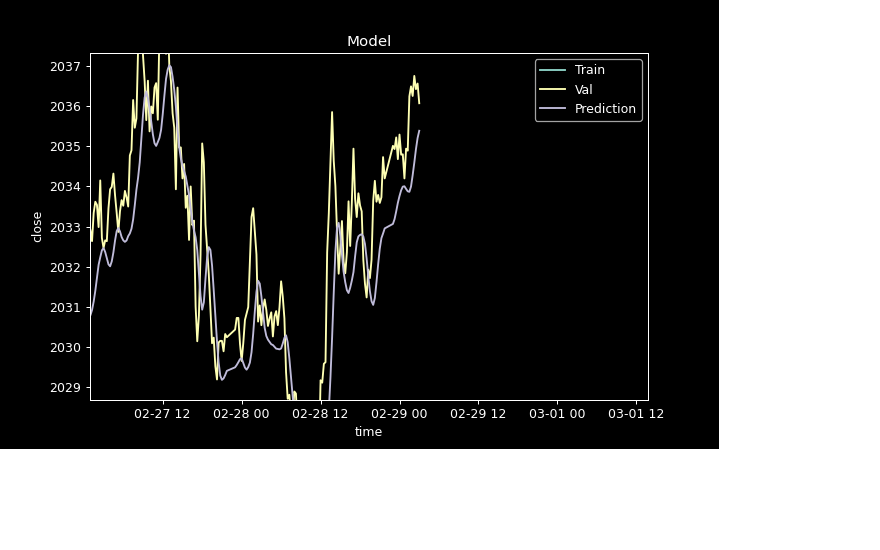

In [75]:
plt.figure(figsize = (8,5))
plt.title("Model")
plt.xlabel('time')
plt.ylabel('close')

plt.plot(Train['close'])
plt.plot(valid['close'])
plt.plot(valid['Predictions'])

plt.legend(['Train','Val','Prediction'], loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


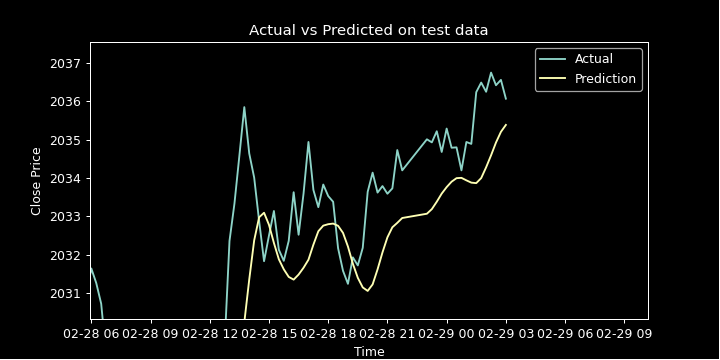

In [78]:
plt.figure(figsize=(8,4))
plt.title('Actual vs Predicted on test data')
plt.plot(valid['close'])
plt.plot(valid['Predictions'])
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend(['Actual','Prediction'], loc='upper right')

plt.show()